#Libraries


In [4]:
!pip install Sastrawi
!pip install contractions
!pip install inflect


/home/irasalsabila/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 2.0.0-ubuntu0.20.04.7-elementary7-ubuntu6.1.1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/irasalsabila/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/irasalsabila/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 2.0.0-ubuntu0.20.04.7-elementary7-ubuntu6.1.1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/irasalsabila/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/irasalsabila/.local/lib/python3.8/site-packages/pkg_resources/__init__

In [5]:
#import needed libraries
import re
import string
import unicodedata
import nltk
import inflect
import pickle
import contractions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, initializers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Concatenate, Input, Embedding, LSTM, Attention, Dense, Dropout, Bidirectional, LSTM, Flatten, Conv1D, GlobalMaxPool1D, MaxPool1D, Reshape, GlobalAveragePooling1D, UpSampling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from datetime import datetime

from keras import initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional, GRU, GlobalMaxPool1D
from keras.utils.np_utils import to_categorical
from keras.backend import clear_session

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('all')

2022-04-12 11:59:18.797617: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 11:59:18.797697: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'tf2'

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.8.0


# Preprocessing

In [ ]:
#removes html
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()
  
#remove between square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#eliminates contractions
def replace_contractions(text):
  """Replace contactions in string of text"""
  return contractions.fix(text)

#denoise text
def denoise_text(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  text = replace_contractions(text)
  return text

In [ ]:
factoryStopword = StopWordRemoverFactory()
stopword = factoryStopword.create_stop_word_remover()
stop_factory = StopWordRemoverFactory().get_stop_words()

def get_stopwords():
  docs = pd.read_csv('/content/stopwords-id.txt', header = None, names= ['stopword'])
  docs = docs['stopword'].tolist()
  return docs

stop_words = get_stopwords()

# Merge stopword
data = set(stop_factory + stop_words)

#remove stopword
def removeStopword(str):
    word_tokens = word_tokenize(str)
    filtered_sentence = [w for w in word_tokens if not w in data]
    return ' '.join(filtered_sentence)

In [ ]:
#cleaning dataset
def cleaning(str):
    #remove non-ascii
    str = unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    str = re.sub("b'|b\"",'',str)
    #remove username inside brackets
    str = re.sub('SENSITIVE-NO',' ',str) 
    #Remove additional white spaces
    str = re.sub('[\s]+', ' ', str)
    #remove URLs
    str = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str)
    #remove punctuations
    str = re.sub(r'[^\w\d#\s]|_',' ',str)
    #remove digit from string
    str = re.sub("\S*\d\S*", "", str).strip()
    #remove digit or numbers
    str = re.sub(r"\b\d+\b", " ", str)
    #to lowercase
    str = str.lower()
    return str

In [ ]:
#remove twitter symbols
def remove_symbols(str):
  #remove RT
  str = re.sub ('RT', '', str)
  #remove @username
  str = re.sub('@[^\s]+', '', str)
  #remove hashtag
  str = re.sub('#[^\s]+', '', str)
  return str

In [ ]:
#normalization of words
normalisasi = pd.read_csv('kamus.csv', encoding = 'latin-1')
normalisasi_map = dict(zip(normalisasi['original'], normalisasi['replacement']))
def normalizing(text):
  return ' '.join([normalisasi_map[word] if word in normalisasi_map else word for word in text.split(' ')])

In [ ]:
factoryStemmer = StemmerFactory()
stemmer = factoryStemmer.create_stemmer()

def stemming(text):
  return stemmer.stem(text)

In [ ]:
#preprocessing dataset function
def preprocessing(str):
  str = remove_symbols(str)
  str = denoise_text(str)
  #str = normalizing(str)
  #str = removeStopword(str)
  str = cleaning(str)
  #str = stemming(str)
  #str = normalizing(str)
  return str

In [ ]:
print(preprocessing('Gelatine Sheet (Bronze) / Gelatine lembaran HALAL (PER 5 LEMBAR) <br><br> @sere_nity'))
print(preprocessing('polisi tembak mati kurir narkotika psikotropika dan obat larang temu kg sabu pil inex gudang narkotika sidoarjo tribunnews.com'))
print(preprocessing('Dokter Sebut Penanganan Rekonstruksi Bayi Dina Oktavia akan Dilakukan Sampai Usia 17 tahun - Halaman 4 - www.tribunnews.com'))
print(preprocessing('Misteri Kematian Hakim Jamaluddin Saat Akan Bercerai, Istri Sudah 7 Kali Diperiksa Polisi - www.voaindonesia.com'))
print(preprocessing('uuuu neo coffee (nctzen/neotizen comment beautiful grass 🤩) @feungkwan emng indihome punya pala? #indihomegakjelas'))
print(preprocessing('Gwen #SpiderManNoWayHome Radit Minta Maaf Ric Flair Sinister Six Venom ARMY Ucok Doctor Strange Indonesia Terkoneksi Dakota Kai Indihome #TokopediaxBLACKPINK #chuckyseries #dukungMUI Andrew Harry Potter Densus 88 Green Goblin #WWENXT https://t.co/o88OJhHAPY'))

gelatine sheet  bronze    gelatine lembaran halal  per  lembar
polisi tembak mati kurir narkotika psikotropika dan obat larang temu kg sabu pil inex gudang narkotika sidoarjo tribunnews com
dokter sebut penanganan rekonstruksi bayi dina oktavia akan dilakukan sampai usia  tahun   halaman
misteri kematian hakim jamaluddin saat akan bercerai  istri sudah  kali diperiksa polisi
uuuu neo coffee  nctzen neotizen comment beautiful grass   emng indihome punya pala
gwen radit minta maaf ric flair sinister six venom army ucok doctor strange indonesia terkoneksi dakota kai indihome andrew harry potter densus  green goblin


# Twitter Sentiment GRU BiLSTM

In [ ]:
print(keras.__version__)
print(tensorflow.__version__)

2.8.0
2.8.0


In [ ]:
#load data
df = pd.read_csv('/content/drive/MyDrive/College/Skripsi Iraa/data/merged.csv') #file.csv
df

,text,label
0,setelah melihat kekacauan jnt aku jadi takut s...,neu
1,jnt lagi ada masalah apa sudah ini paket sudah...,neg
2,jnt tidak ada perubahan sama sekali jujur kese...,neg
3,aku chat wasap ke jnt kak,neu
4,benar benar sekarang bukan seram seller lagi t...,neg
...,...,...
8256,suka banget sama kurir nya anteraja ramah banget,pos
8257,jujur iya anteraja itu secepet itu,pos
8258,anteraja paling the best tidak pernah ngecewai...,pos
8259,asli sih pakai anteraja cepat banget sampai nya,pos


In [ ]:
# checking nan values
df.isnull().values.any()

# if there is nan
# df = df.dropna()

False

In [ ]:
# length of data
len(df)

8261

In [ ]:
# drop unused column
df = df.drop(['Unnamed: 0', 'label_id'], axis = True)
df.head()

In [ ]:
# checking duplicated data
df.duplicated().sum()

154

In [ ]:
# delete duplicated data
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
# reset index after delete duplicated
df = df.reset_index(drop=True)
df

,text,label
0,setelah melihat kekacauan jnt aku jadi takut s...,neu
1,jnt lagi ada masalah apa sudah ini paket sudah...,neg
2,jnt tidak ada perubahan sama sekali jujur kese...,neg
3,aku chat wasap ke jnt kak,neu
4,benar benar sekarang bukan seram seller lagi t...,neg
...,...,...
8102,suka banget sama kurir nya anteraja ramah banget,pos
8103,jujur iya anteraja itu secepet itu,pos
8104,anteraja paling the best tidak pernah ngecewai...,pos
8105,asli sih pakai anteraja cepat banget sampai nya,pos


In [ ]:
#convert label string to categorical
df.dropna(inplace = True)
df['label_id'] = df['label'].factorize()[0]
kategori_id = df[['label', 'label_id']].drop_duplicates().sort_values('label_id')
kategori_to_id = dict(kategori_id.values)
id_to_kategori = dict(kategori_id[['label_id', 'label']].values)

#show data id_to_kategori
id_to_kategori

{0: 'neu', 1: 'neg', 2: 'pos'}

neg    3875
neu    2203
pos    2183
Name: label, dtype: int64

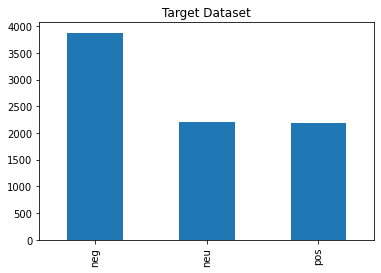

In [ ]:
#knowing dataset counts
target = df['label'].value_counts()
target.plot(kind='bar', title='Target Dataset')

#show dataset
target

In [ ]:
#balancing dataset
class_0, class_1, class_2= df['label'].value_counts()

class_0, class_1, class_2

(3826, 2145, 2136)

Random samping: 
neu    2136
neg    2136
pos    2136
Name: label, dtype: int64
Total sentences:  6408


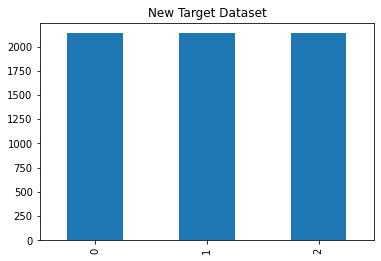

In [ ]:
dataset_class_0 = df[df['label_id'] == 0]
dataset_class_1 = df[df['label_id'] == 1]
dataset_class_2 = df[df['label_id'] == 2]

#making dataset as much as label 2
dataset_class_0 = dataset_class_0.sample(class_2)
dataset_class_1 = dataset_class_1.sample(class_2)
dataset_class_2 = dataset_class_2.sample(class_2)

df = pd.concat([dataset_class_0, dataset_class_1, dataset_class_2], axis=0)

print("Random samping: ")
print(df.label.value_counts())

df.label_id.value_counts().plot(kind='bar', title='New Target Dataset')
print('Total sentences: ', len(df))

In [ ]:
df

,text,label,label_id
0,setelah melihat kekacauan jnt aku jadi takut s...,neu,0
1,jnt lagi ada masalah apa sudah ini paket sudah...,neg,1
2,jnt tidak ada perubahan sama sekali jujur kese...,neg,1
3,aku chat wasap ke jnt kak,neu,0
4,benar benar sekarang bukan seram seller lagi t...,neg,1
...,...,...,...
8256,suka banget sama kurir nya anteraja ramah banget,pos,2
8257,jujur iya anteraja itu secepet itu,pos,2
8258,anteraja paling the best tidak pernah ngecewai...,pos,2
8259,asli sih pakai anteraja cepat banget sampai nya,pos,2


In [ ]:
#checking dataset value
label = df['label_id'].values
text = df['text'].values

print('Value of [label_id]:', label, "\n")
print('Value of [text]:', text)

Value of [label_id]: [0 1 1 ... 2 2 0] 

Value of [text]: ['setelah melihat kekacauan jnt aku jadi takut sama paketku yang on the way semoga dapat kurir mas mas biasanya t t'
 'jnt lagi ada masalah apa sudah ini paket sudah hari saya tidak sampai sampeee biasanya sehari besoknya langsung sampai hhhhh'
 'jnt tidak ada perubahan sama sekali jujur kesellll tapi alhamdulillah nya di dom ku tidak ada oknum yang kayak begitu sih kakak'
 ... 'anteraja paling the best tidak pernah ngecewain love love deh'
 'asli sih pakai anteraja cepat banget sampai nya'
 'dari kurir anteraja kita belajar kalau banyaknya kasus penipuan lowongan pekerjaan di tidak jelas itu ternyata ada backinganny']


In [ ]:
#max features
maxfeatures = 10000

#tokenization
tokenizer = Tokenizer(num_words = maxfeatures)
tokenizer.fit_on_texts(text)

In [ ]:
#max sequential per word in NN
maxseqlen = max([len(i.split()) for i in text])
print(maxseqlen)

70


In [ ]:
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, maxlen = maxseqlen)
y = to_categorical(label, num_classes = 3)

print("Shape of data tensor ['text']:", X.shape)
print("Shape of data tensor ['label']:", y.shape)

Shape of data tensor ['text']: (8261, 70)
Shape of data tensor ['label']: (8261, 3)


In [ ]:
#tokening word index
idx_token = tokenizer.word_index

In [ ]:
#determine vocab data used
vocab = max([len(idx_token)]) + 1
vocab

10738

In [ ]:
#initializer
initializer = initializers.RandomUniform(minval = -0.05, maxval = 0.05, seed = 123)

#split dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.15, random_state = 128)

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

(7021, 70) (7021, 3)
(1240, 70) (1240, 3)


In [ ]:
#architecture model
model = Sequential()
model.add(Embedding(input_dim = maxfeatures, output_dim = 128, input_length = maxseqlen, embeddings_initializer = initializer))
model.add(Bidirectional(LSTM(512, return_sequences = True, kernel_initializer = initializer)))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


opt = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0012, rho=0.7, momentum=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 70, 1024)         2625536   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 1024)             0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [ ]:
#declare checkpoint variable and early stopping to get best model
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3)

In [ ]:
#training model
start_time = datetime.now()
history = model.fit(Xtrain, ytrain,
                    batch_size = 170, epochs = 12, shuffle = True,
                    validation_split = 0.1, verbose = 1,
                    callbacks=early_stop)
end_time = datetime.now()
print("Time out: {}".format(end_time - start_time))

Epoch 1/12
38/38 [==============================] - 185s 5s/step - loss: 1.0322 - accuracy: 0.4696 - val_loss: 1.0597 - val_accuracy: 0.4552
Epoch 2/12
38/38 [==============================] - 178s 5s/step - loss: 0.8858 - accuracy: 0.5470 - val_loss: 0.8101 - val_accuracy: 0.6230
Epoch 3/12
38/38 [==============================] - 179s 5s/step - loss: 0.8332 - accuracy: 0.5901 - val_loss: 0.8063 - val_accuracy: 0.6202
Epoch 4/12
38/38 [==============================] - 179s 5s/step - loss: 0.7741 - accuracy: 0.6186 - val_loss: 1.1589 - val_accuracy: 0.5917
Epoch 5/12
38/38 [==============================] - 179s 5s/step - loss: 0.7381 - accuracy: 0.6489 - val_loss: 1.0611 - val_accuracy: 0.6344
Epoch 6/12
38/38 [==============================] - 225s 6s/step - loss: 0.6908 - accuracy: 0.6857 - val_loss: 0.6764 - val_accuracy: 0.7198
Epoch 7/12
38/38 [==============================] - 224s 6s/step - loss: 0.6374 - accuracy: 0.7165 - val_loss: 0.7009 - val_accuracy: 0.7055
Epoch 8/12
38

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

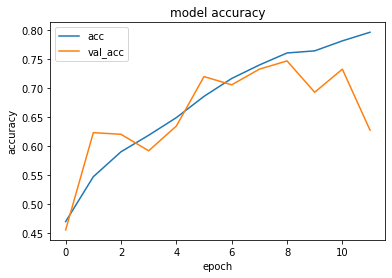

In [ ]:
import matplotlib.pyplot as plt

plt.plot (history.history['accuracy'])
plt.plot (history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

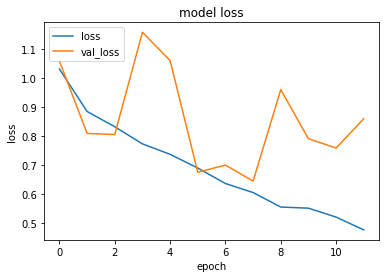

In [ ]:
import matplotlib.pyplot as plt

plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [ ]:
#build eveluation function
def evaluation(model, X, Y):
  global Y_pred, Y_act
  Y_pred = model.predict(X)
  Y_pred_class = np.argmax(Y_pred, axis=1)
  rounded_labels=np.argmax(Y, axis=1)
  Y_act = rounded_labels
  
  accuracy = accuracy_score(Y_act, Y_pred_class)
  return accuracy

In [ ]:
accuracy = evaluation(model, Xtest, ytest)
print('accuracy: %.3f' % (accuracy * 100), '%')

accuracy: 62.661 %


In [ ]:
id_to_kategori

{0: 'neu', 1: 'neg', 2: 'pos'}

In [ ]:
from sklearn.metrics import classification_report
target = ['neu', 'neg', 'pos']
print(confusion_matrix(Y_act, np.argmax(Y_pred, axis=1)))
print(classification_report(Y_act, np.argmax(Y_pred, axis = 1), target_names = target))

[[113  21 204]
 [ 28 376 181]
 [ 18  11 288]]
              precision    recall  f1-score   support

         neu       0.71      0.33      0.45       338
         neg       0.92      0.64      0.76       585
         pos       0.43      0.91      0.58       317

    accuracy                           0.63      1240
   macro avg       0.69      0.63      0.60      1240
weighted avg       0.74      0.63      0.63      1240



In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print("confusion matrix: \n", confusion_matrix(Y_act, np.argmax(Y_pred, axis = 1)))

# Accuracy
print("accuracy: ", accuracy_score(Y_act, np.argmax(Y_pred, axis = 1)))

# Recall
from sklearn.metrics import recall_score
print("recall: ", recall_score(Y_act, np.argmax(Y_pred, axis = 1), average=None))

# Precision
from sklearn.metrics import precision_score
print("precission: ", precision_score(Y_act, np.argmax(Y_pred, axis = 1), average=None))

confusion matrix: 
 [[113  21 204]
 [ 28 376 181]
 [ 18  11 288]]
accuracy:  0.6266129032258064
recall:  [0.33431953 0.64273504 0.90851735]
precission:  [0.71069182 0.92156863 0.42793462]


In [ ]:
import pickle
with open('/content/drive/MyDrive/College/Skripsi Iraa/pickle h5/bilstm-merged-26mar.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save('/content/drive/MyDrive/College/Skripsi Iraa/pickle h5/bilstm-merged-26mar.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/College/Skripsi Iraa/pickle h5/bilstm-merged-26mar.h5')

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 70, 128)           1280000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 70, 1024)         2625536   
 nal)                                                            
                                                                 
 global_max_pooling1d_5 (Glo  (None, 1024)             0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 128)               131200    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)               

In [ ]:
#new data
test = ['Gilakk tumben dah sampenya lama banget',
        'Gilakkk tumben dah sampe',
        'Ongkir Surabaya Jogja berapa min',
        'Aduh ekspedisinya ruwet banget, gak sampe-sampe',
        'Alhamdulillah kurir di tempatku Amanah sih',
        'Halo minnn, tolong cek dm kuu'
        ]

#expected
#neg, neg, pos, neu, neu, pos

In [ ]:
#tokenizing newdata
newdata = tokenizer.texts_to_sequences(test)
newdata = pad_sequences(newdata, maxlen = maxseqlen)

In [ ]:
model_predict = model.predict(newdata)
model_label = np.argmax(model_predict, axis = 1)
model_probability = model_predict.max(axis = 1)

In [ ]:
#proccess model into prediction and probability of newdata
model_labeled = []
model_sentence = []
model_probabilities = []
for model_unlabeled, model_label, model_probability in zip(test, model_label, model_probability):
  print('"{}"'.format(model_unlabeled))
  u = model_unlabeled
  l = id_to_kategori[model_label]
  model_labeled.append(l)
  model_sentence.append(u)
  model_probabilities.append(model_probability)

  print("  - Prediction: '{}'".format(id_to_kategori[model_label]))
  print("  - Probability: '{}'".format(model_probability))
  print("")

"Gilakk tumben dah sampenya lama banget"
  - Prediction: 'neg'
  - Probability: '0.9850375056266785'

"Gilakkk tumben dah sampe"
  - Prediction: 'neg'
  - Probability: '0.6625643372535706'

"Ongkir Surabaya Jogja berapa min"
  - Prediction: 'neu'
  - Probability: '0.4499388635158539'

"Aduh ekspedisinya ruwet banget, gak sampe-sampe"
  - Prediction: 'neg'
  - Probability: '0.6309604644775391'

"Alhamdulillah kurir di tempatku Amanah sih"
  - Prediction: 'pos'
  - Probability: '0.6311646699905396'

"Halo minnn, tolong cek dm kuu"
  - Prediction: 'neu'
  - Probability: '0.49786800146102905'

